## Análisis de datos - Data transaccional de tarjetas de crédito

### Contexto

Es importante que las compañías de tarjetas de crédito puedan reconocer las transacciones fraudulentas de tarjetas de crédito para que los clientes no cobren por los artículos que no compraron.

### Descripción del dataset


El dataset contiene transacciones realizadas con tarjetas de crédito en septiembre de 2013 por los titulares de tarjetas europeos. Este conjunto de datos presenta las transacciones que se produjeron en dos días, donde tenemos 492 fraudes de un total de 284,807 transacciones. 

El conjunto de datos está muy desequilibrado, la clase positiva (fraudes) representa el 0.172% de todas las transacciones.

Contiene solo variables de entrada numéricas que son el resultado de una transformación de PCA. Desafortunadamente, debido a problemas de confidencialidad, no podemos proporcionar las características originales y más información de fondo sobre los datos. Las características V1, V2, ... V28 son los componentes principales obtenidos con PCA, las únicas características que no se han transformado con PCA son 'Tiempo' y 'Cantidad'. La característica 'Tiempo' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La función 'Cantidad' es la cantidad de la transacción, esta función se puede utilizar para el aprendizaje basado en el costo dependiente del ejemplo. La característica 'Clase' es la variable de respuesta y toma valor 1 en caso de fraude y 0 en caso contrario.

### Análisis Exploratorio de datos (EDA)

#### Importando paquetes necesarios

In [1]:
%matplotlib inline
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

#### Lectura de data

In [2]:
df = pd.read_csv('creditcard.csv')

Veamos las dimensiones del dataframe

In [3]:
print('Este dataframe tiene {} filas y {} columnas.'.format(df.shape[0], df.shape[1]))

Este dataframe tiene 284807 filas y 31 columnas.


#### Mostrando primeros 5 registros

In [4]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
122004,76399.0,-1.182123,1.597172,-0.170299,0.952805,0.204497,-0.235946,-0.206059,1.016457,-1.031114,...,0.219891,0.328637,-0.163696,-0.439955,-0.339224,-0.306808,-0.158066,0.001059,1.00,0
38388,39378.0,-0.973943,1.171064,0.907219,1.350711,0.251160,-0.015635,0.608004,0.431914,-1.702975,...,0.240438,0.488302,-0.226887,0.048213,0.498952,-0.001601,-0.045287,-0.027964,55.63,0
163421,115927.0,-1.044214,0.229044,-0.262634,-0.819236,-0.189164,-0.011647,2.256656,-0.502985,-0.362041,...,0.201041,0.729734,-0.210965,0.667587,0.094615,0.732921,-0.076384,0.172522,329.75,0
279519,168923.0,0.027135,0.810858,0.116672,-0.812550,0.716499,-0.519337,0.926335,-0.046653,-0.315026,...,-0.234731,-0.523917,0.003077,-0.492247,-0.444843,0.149306,0.243352,0.083324,6.27,0
88280,62071.0,-0.905473,1.203747,1.075991,-1.022194,-0.056442,-0.689185,0.421249,0.388309,-0.579808,...,0.029532,0.115286,-0.037665,0.159536,-0.316801,0.789120,0.161410,0.115494,1.00,0


#### Viendo los tipos de datos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

#### Nos centraremos en los campos que no están anonimizados

In [6]:
pd.set_option('precision', 3)
df.loc[:, ['Time', 'Amount']].describe()

,Time,Amount
count,284807.000,284807.000
mean,94813.860,88.350
std,47488.146,250.120
min,0.000,0.000
25%,54201.500,5.600
50%,84692.000,22.000
75%,139320.500,77.165
max,172792.000,25691.160


#### Visualizamos el tiempo y el monto

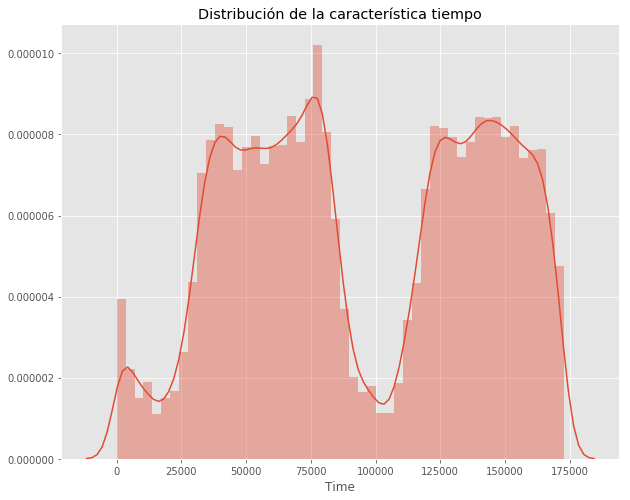

In [7]:
plt.figure(figsize=(10,8))
plt.title('Distribución de la característica tiempo')
sns.distplot(df.Time)

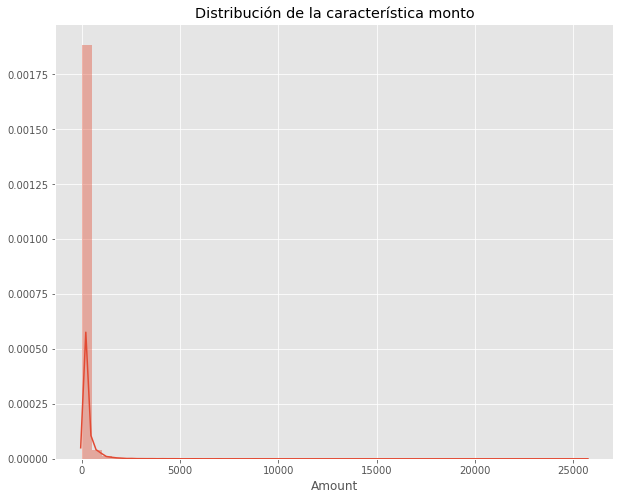

In [8]:
plt.figure(figsize=(10,8))
plt.title('Distribución de la característica monto')
sns.distplot(df.Amount)

El valor medio de todas las transacciones es 88.35 dólares, mientras que la transacción más grande registrada en este conjunto de datos asciende a 25,691.16 dólares

#### fraude vs. transacciones normales

In [9]:

counts = df.Class.value_counts()
normal = counts[0]
fraudulent = counts[1]
perc_normal = (normal/(normal+fraudulent))*100
perc_fraudulent = (fraudulent/(normal+fraudulent))*100
print('Tenemos {} transacciones no fraudulentas ({:.3f}%) y {} transacciones fraudulentas ({:.3f}%).'.format(normal, perc_normal, fraudulent, perc_fraudulent))

Tenemos 284315 transacciones no fraudulentas (99.827%) y 492 transacciones fraudulentas (0.173%).


Text(0.5,0,'Clase (0:No Fraudulento, 1:Fraudulento)')

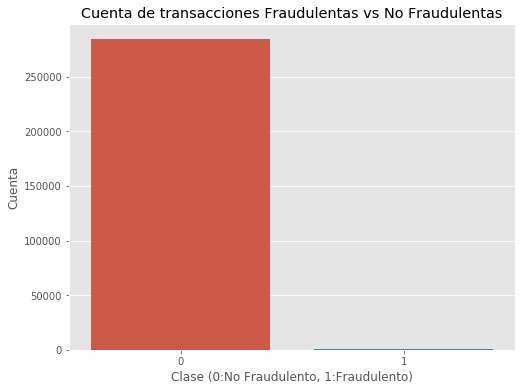

In [10]:
plt.figure(figsize=(8,6))
sns.barplot(x=counts.index, y=counts)
plt.title('Cuenta de transacciones Fraudulentas vs No Fraudulentas')
plt.ylabel('Cuenta')
plt.xlabel('Clase (0:No Fraudulento, 1:Fraudulento)')

#### Correlaciones

In [11]:
corr = df.corr()
corr

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000,1.174e-01,-1.059e-02,-4.196e-01,-1.053e-01,1.731e-01,-6.302e-02,8.471e-02,-3.695e-02,-8.660e-03,...,4.474e-02,1.441e-01,5.114e-02,-1.618e-02,-2.331e-01,-4.141e-02,-5.135e-03,-9.413e-03,-1.060e-02,-1.232e-02
V1,0.117,1.000e+00,4.697e-17,-1.424e-15,1.755e-17,6.391e-17,2.398e-16,1.992e-15,-9.491e-17,2.170e-16,...,-1.755e-16,7.477e-17,9.809e-16,7.354e-17,-9.805e-16,-8.622e-17,3.208e-17,9.821e-16,-2.277e-01,-1.013e-01
V2,-0.011,4.697e-17,1.000e+00,2.512e-16,-1.126e-16,-2.040e-16,5.025e-16,3.966e-16,-4.414e-17,-5.729e-17,...,8.444e-17,2.501e-16,1.060e-16,-8.142e-18,-4.262e-17,2.602e-16,-4.478e-16,-3.676e-16,-5.314e-01,9.129e-02
V3,-0.420,-1.424e-15,2.512e-16,1.000e+00,-3.417e-16,-1.437e-15,1.432e-15,2.169e-15,3.433e-16,-4.234e-16,...,-2.972e-17,4.648e-16,2.115e-17,-9.352e-17,4.771e-16,6.522e-16,6.240e-16,7.727e-16,-2.109e-01,-1.930e-01
V4,-0.105,1.755e-17,-1.126e-16,-3.417e-16,1.000e+00,-1.941e-15,-2.713e-16,1.556e-16,5.196e-16,3.860e-16,...,-9.977e-17,2.100e-16,6.003e-17,2.230e-16,5.395e-16,-6.180e-16,-6.403e-17,-5.864e-17,9.873e-02,1.334e-01
V5,0.173,6.391e-17,-2.040e-16,-1.437e-15,-1.941e-15,1.000e+00,7.926e-16,-4.210e-16,7.589e-16,4.205e-16,...,-1.369e-16,5.060e-16,1.638e-16,-9.286e-16,5.625e-16,9.145e-16,4.466e-16,-3.299e-16,-3.864e-01,-9.497e-02
V6,-0.063,2.398e-16,5.025e-16,1.432e-15,-2.713e-16,7.926e-16,1.000e+00,1.429e-16,-1.707e-16,1.114e-16,...,-1.576e-16,-3.363e-16,-7.232e-17,-1.262e-15,1.082e-15,-2.378e-16,-2.624e-16,4.813e-16,2.160e-01,-4.364e-02
V7,0.085,1.992e-15,3.966e-16,2.169e-15,1.556e-16,-4.210e-16,1.429e-16,1.000e+00,-8.692e-17,7.933e-16,...,1.939e-16,-1.058e-15,2.328e-16,-2.590e-17,1.174e-15,-7.335e-16,-5.887e-16,-6.837e-17,3.973e-01,-1.873e-01
V8,-0.037,-9.491e-17,-4.414e-17,3.433e-16,5.196e-16,7.589e-16,-1.707e-16,-8.692e-17,1.000e+00,2.901e-16,...,-2.412e-16,5.476e-16,3.897e-16,-1.803e-16,-1.391e-16,-1.210e-16,1.734e-16,-4.484e-16,-1.031e-01,1.988e-02
V9,-0.009,2.170e-16,-5.729e-17,-4.234e-16,3.860e-16,4.205e-16,1.114e-16,7.933e-16,2.901e-16,1.000e+00,...,4.578e-17,2.872e-17,5.929e-16,-2.346e-16,1.100e-15,-1.389e-15,-2.287e-16,9.147e-16,-4.425e-02,-9.773e-02


#### Mapa de calor para visualización de correlaciones

Text(0.5,1,'Mapa de calor de correlación')

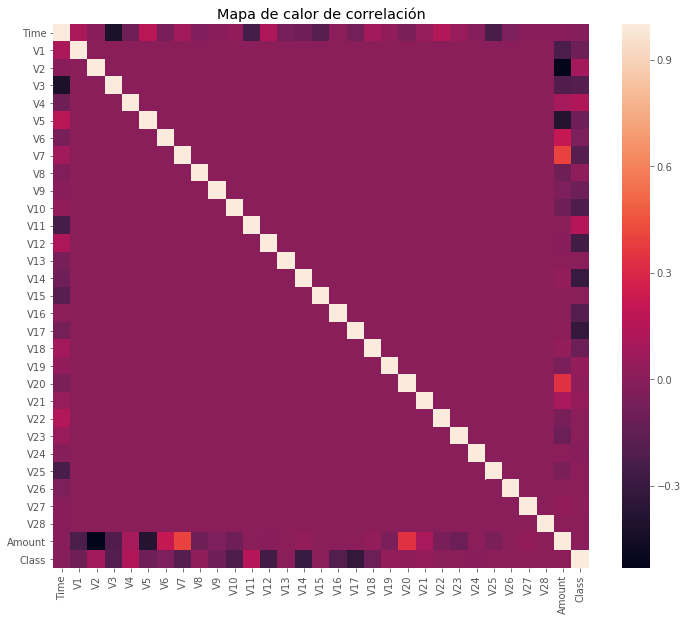

In [12]:
corr = df.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr)
plt.title('Mapa de calor de correlación')

In [13]:
# #skewness
# skew_ = df.skew()
# skew_

### Preparación de los datos

**Escalando tiempo y monto**

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler2 = StandardScaler()

Escalando tiempo

In [15]:
scaled_time = scaler.fit_transform(df[['Time']])
flat_list1 = [item for sublist in scaled_time.tolist() for item in sublist]
scaled_time = pd.Series(flat_list1)

Escalando monto

In [16]:
scaled_amount = scaler2.fit_transform(df[['Amount']])
flat_list2 = [item for sublist in scaled_amount.tolist() for item in sublist]
scaled_amount = pd.Series(flat_list2)

Concatenando las nuevas columnas creadas al dataframe original

In [17]:
df = pd.concat([df, scaled_amount.rename('scaled_amount'), scaled_time.rename('scaled_time')], axis=1)
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
177801,123350.0,2.015,-0.973,-1.707,-0.949,-0.102,0.335,-0.940,0.114,-0.213,...,-0.070,-0.441,-0.053,-0.082,0.010,-0.011,99.00,0,0.043,0.601
250994,155159.0,2.062,-0.042,-1.255,0.365,-0.073,-1.256,0.175,-0.350,0.671,...,0.010,0.018,0.231,-0.098,-0.014,-0.059,1.00,0,-0.349,1.271
281857,170472.0,0.036,0.883,0.297,-0.596,0.462,-1.029,1.027,-0.202,-0.098,...,0.074,-0.011,-0.493,0.142,0.252,0.098,4.26,0,-0.336,1.593
92608,64009.0,1.251,-0.645,0.371,-0.668,-1.083,-0.885,-0.456,-0.161,-1.156,...,-0.169,0.587,0.556,-0.122,-0.012,0.015,68.97,0,-0.077,-0.649
181896,125167.0,1.954,-0.452,-0.277,0.532,-0.805,-0.575,-0.583,-0.072,1.466,...,0.062,0.014,-0.041,-0.154,0.040,-0.035,23.53,0,-0.259,0.639


Eliminando las viejas columnas de monto y tiempo

In [18]:
df.drop(['Amount', 'Time'], axis=1, inplace=True)

### Creación de un conjunto de entrenamiento para un conjunto de datos muy desequilibrado

**Partiendo la data en entrenamiento y test**

In [19]:
mask = np.random.rand(len(df)) < 0.9
train = df[mask]
test = df[~mask]
print('Dimensiones de la data de entrenamiento: {}\nDimensiones de la data de prueba: {}'.format(train.shape, test.shape))

Dimensiones de la data de entrenamiento: (256346, 31)
Dimensiones de la data de prueba: (28461, 31)


In [20]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

**Creating a subsample data set with balanced class distributions**

¿Cuantos registros aleatorias para las transacciones no fraudulentas necesitamos?

In [21]:
no_of_frauds = train.Class.value_counts()[1]
print('Hay {} transacciones fraudulentas en la data de entrenamiento.'.format(no_of_frauds))

Hay 437 transacciones fraudulentas en la data de entrenamiento.


Selección aleatoria de 438 transacciones no fraudulentas

In [22]:
non_fraud = train[train['Class'] == 0]
fraud = train[train['Class'] == 1]

In [23]:
selected = non_fraud.sample(no_of_frauds)
selected.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
36365,1.257,0.670,-0.305,0.903,-0.030,-1.579,0.460,-0.386,-0.308,-0.622,...,-0.213,-0.049,0.648,0.556,0.346,-0.028,0.042,0,-0.350,-1.150
137430,-0.131,0.278,1.713,-0.639,-0.142,0.819,-0.667,-0.612,1.941,-1.237,...,-0.875,-0.399,-0.012,1.325,0.692,-0.003,0.135,0,-0.197,0.055
141299,-0.999,1.348,1.300,-0.232,0.632,-0.664,1.135,-0.368,1.100,-0.952,...,-0.681,-0.340,-0.079,0.607,-0.450,-0.716,-0.453,0,-0.335,0.302
201117,-2.015,-1.908,1.001,-0.713,-1.726,3.105,0.677,1.271,1.286,-2.077,...,1.420,1.346,-1.335,-0.888,0.371,-0.026,0.137,0,1.950,1.021
134692,2.100,0.154,-2.123,0.652,0.647,-0.815,0.083,-0.288,1.965,-0.719,...,0.630,-0.100,0.314,0.341,0.850,-0.109,-0.055,0,-0.334,-0.070


Concatenando ambos hacia una sub-muestra con igual distribución de clase

In [24]:
selected.reset_index(drop=True, inplace=True)
fraud.reset_index(drop=True, inplace=True)

In [25]:
subsample = pd.concat([selected, fraud])
len(subsample)

874

Ordenando el dataset

In [26]:
subsample = subsample.sample(frac=1).reset_index(drop=True)
subsample.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-0.920,0.608,0.627,0.252,1.163,-1.437,0.764,-0.197,-0.571,-1.147,...,0.596,-0.470,-0.025,0.919,0.201,0.026,0.096,0,-0.247,0.610
1,-0.747,1.345,1.089,0.984,-0.309,-0.635,0.405,0.326,-0.784,-0.378,...,0.703,0.006,0.619,-0.390,-0.347,-0.062,0.096,0,-0.297,-0.738
2,-1.142,1.928,-3.905,-0.074,-0.045,-1.757,-1.217,0.365,-2.770,-3.216,...,-0.531,-0.329,0.393,0.568,0.787,-0.146,0.076,1,-0.253,0.661
3,-0.969,1.002,0.594,-1.394,-0.022,-0.666,0.842,0.265,-0.487,-1.030,...,-0.558,0.068,-0.413,-0.121,0.705,0.100,0.110,0,-0.033,-0.816
4,1.238,0.224,0.539,0.763,-0.470,-0.966,-0.057,-0.276,1.437,-0.425,...,-0.458,0.022,0.350,0.320,0.353,-0.073,0.009,0,-0.273,-1.483
5,-6.751,5.367,-10.055,9.064,-7.968,-2.264,-10.318,4.238,-5.324,-11.092,...,-0.349,0.425,0.675,-0.784,-0.247,1.160,0.198,1,0.485,-0.020
6,0.875,-0.655,-0.042,1.969,1.461,4.911,-1.093,1.254,0.586,0.258,...,-0.854,-0.117,1.016,0.519,-0.058,0.037,0.049,0,0.201,-0.857
7,0.330,3.713,-5.776,6.078,1.667,-2.420,-0.813,0.133,-2.214,-5.134,...,-0.652,-0.552,-0.717,1.416,0.555,0.531,0.404,1,-0.349,-1.838
8,1.370,-1.211,0.436,-1.390,-1.481,-0.585,-0.910,-0.220,-1.853,1.348,...,-0.773,0.030,-0.144,0.197,-0.391,0.032,0.042,0,0.047,-0.433
9,-1.533,2.233,-5.923,3.387,-0.153,-1.420,-3.879,1.445,-1.466,-5.208,...,-0.071,-0.490,-0.360,0.051,1.096,0.472,-0.107,1,-0.350,0.331


Graficando las clases

Text(0.5,0,'Clase (0:No Fraudulenta, 1:Fraudulenta)')

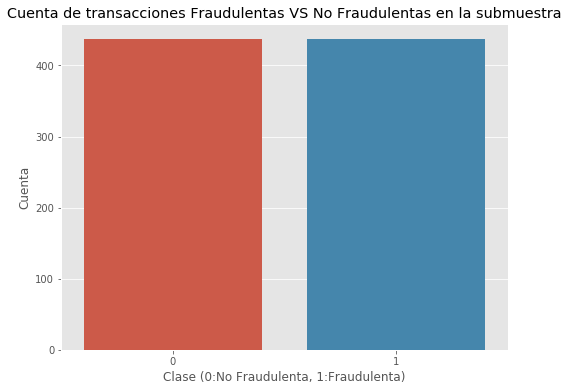

In [27]:
new_counts = subsample.Class.value_counts()
plt.figure(figsize=(8,6))
sns.barplot(x=new_counts.index, y=new_counts)
plt.title('Cuenta de transacciones Fraudulentas VS No Fraudulentas en la submuestra')
plt.ylabel('Cuenta')
plt.xlabel('Clase (0:No Fraudulenta, 1:Fraudulenta)')

Viendo las correlaciones con las clases una vez más

In [28]:
corr = subsample.corr()
corr = corr[['Class']]
corr

,Class
V1,-0.418
V2,0.481
V3,-0.567
V4,0.690
V5,-0.367
V6,-0.397
V7,-0.471
V8,0.053
V9,-0.551
V10,-0.623


Correlaciones negativas menores a -0.5

In [29]:
corr[corr.Class < -0.5]

,Class
V3,-0.567
V9,-0.551
V10,-0.623
V12,-0.673
V14,-0.747
V16,-0.590
V17,-0.555


Correlaciones positivas mayores a 0.5

In [30]:
corr[corr.Class > 0.5]

,Class
V4,0.690
V11,0.682
Class,1.000


Visualización de características con alta correlación negativa

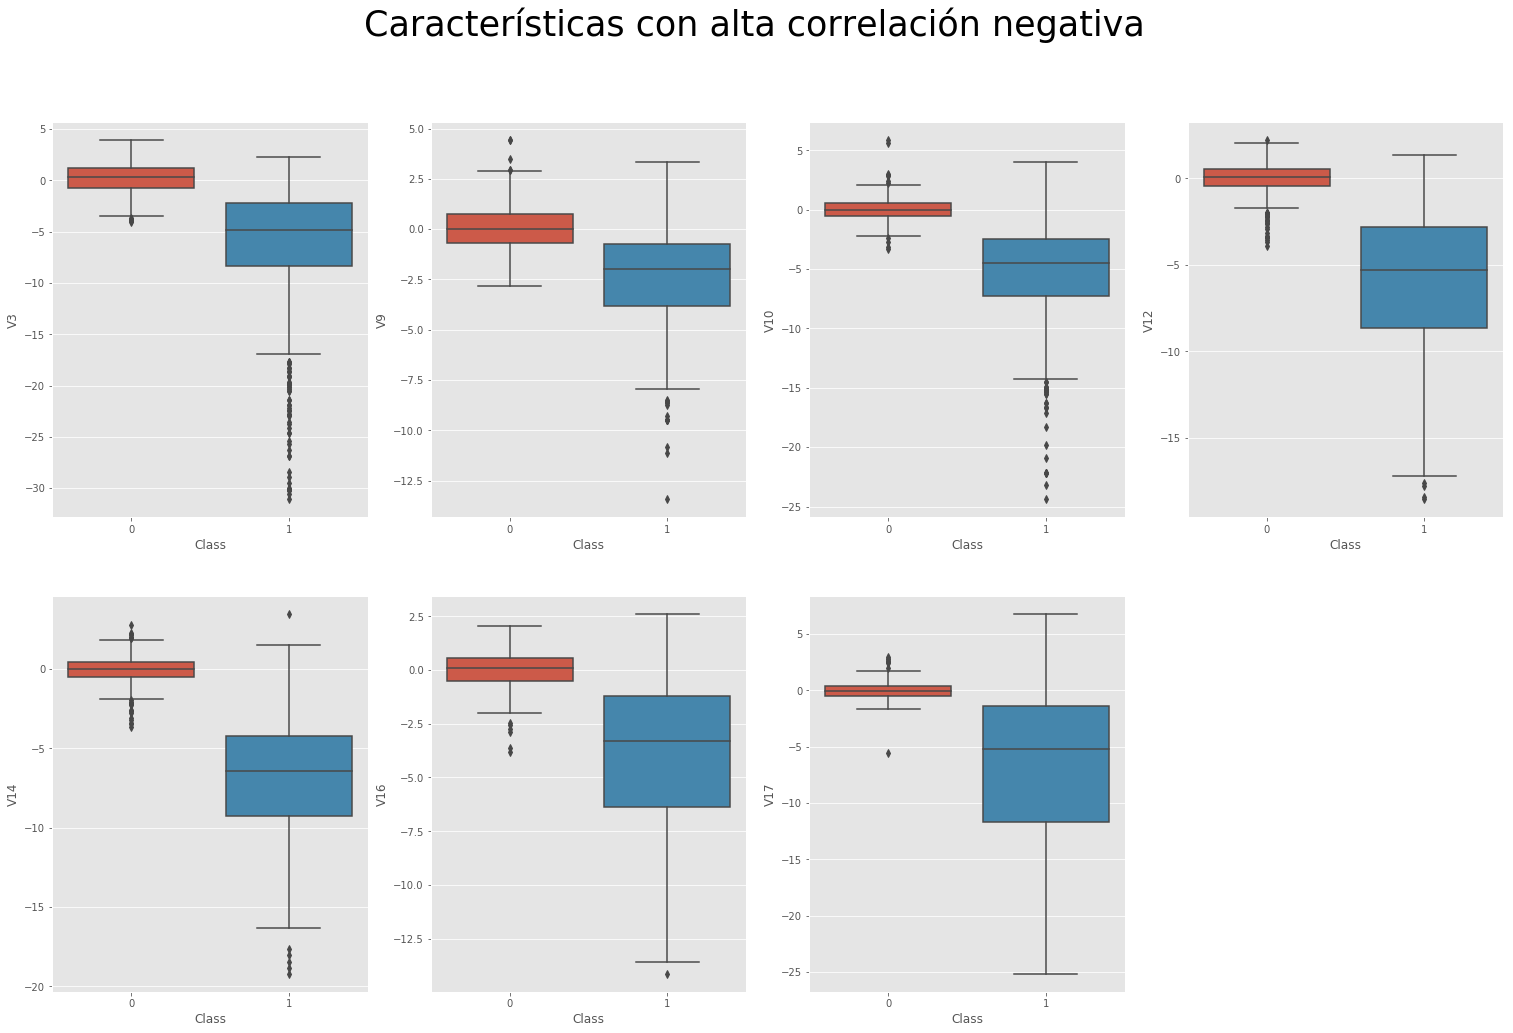

In [31]:
f, axes = plt.subplots(nrows=2, ncols=4, figsize=(26,16))

f.suptitle('Características con alta correlación negativa', size=35)
sns.boxplot(x="Class", y="V3", data=subsample, ax=axes[0,0])
sns.boxplot(x="Class", y="V9", data=subsample, ax=axes[0,1])
sns.boxplot(x="Class", y="V10", data=subsample, ax=axes[0,2])
sns.boxplot(x="Class", y="V12", data=subsample, ax=axes[0,3])
sns.boxplot(x="Class", y="V14", data=subsample, ax=axes[1,0])
sns.boxplot(x="Class", y="V16", data=subsample, ax=axes[1,1])
sns.boxplot(x="Class", y="V17", data=subsample, ax=axes[1,2])
f.delaxes(axes[1,3])

Visualización de características con alta correlación positiva

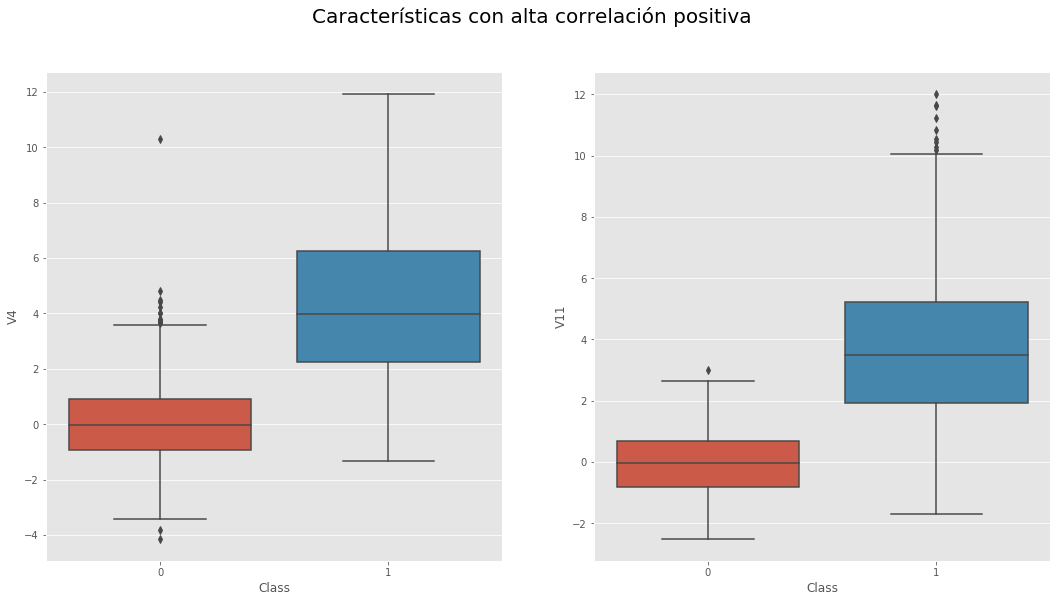

In [32]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

f.suptitle('Características con alta correlación positiva', size=20)
sns.boxplot(x="Class", y="V4", data=subsample, ax=axes[0])
sns.boxplot(x="Class", y="V11", data=subsample, ax=axes[1])

**Removiendo outliers extremos**

In [33]:
Q1 = subsample.quantile(0.25)
Q3 = subsample.quantile(0.75)
IQR = Q3 - Q1

df2 = subsample[~((subsample < (Q1 - 2.5 * IQR)) |(subsample > (Q3 + 2.5 * IQR))).any(axis=1)]

In [34]:
len_after = len(df2)
len_before = len(subsample)
len_difference = len(subsample) - len(df2)
print('Reducimos el tamaño de nuestra data de {} transacciones a {} transacciones.'.format(len_before, len_after))


Reducimos el tamaño de nuestra data de 874 transacciones a 619 transacciones.


**Reducción de dimensionalidad con t-SNE para visualización de clases en 2 dimensiones**

In [35]:
from sklearn.manifold import TSNE

X = df2.drop('Class', axis=1)
y = df2['Class']

Algoritmo T-SNE

In [36]:
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

Gráfico de dispersión para T-SNE

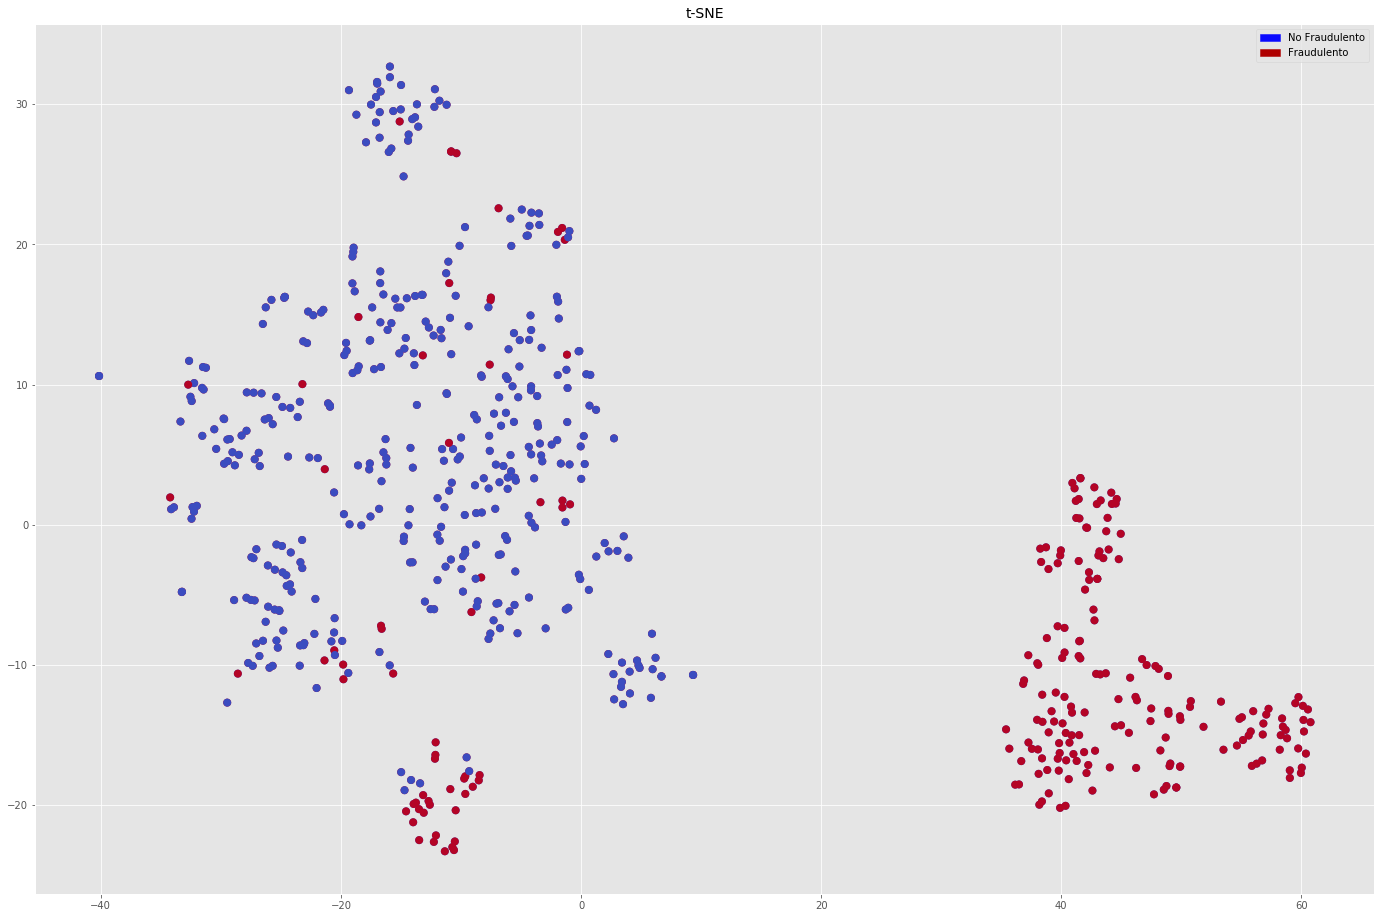

In [37]:
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(24,16))


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraudulento')
red_patch = mpatches.Patch(color='#AF0000', label='Fraudulento')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraudulento', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraudulento', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])


### Modelado

**Algoritmos de clasificación**

In [38]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Separación en train - test

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
X_train = X_train.values
X_validation = X_test.values
y_train = y_train.values
y_validation = y_test.values

In [41]:
print('X_shapes:\n', 'X_train:', 'X_validation:\n', X_train.shape, X_validation.shape, '\n')
print('Y_shapes:\n', 'Y_train:', 'Y_validation:\n', y_train.shape, y_validation.shape)

X_shapes:
 X_train: X_validation:
 (495, 30) (124, 30) 

Y_shapes:
 Y_train: Y_validation:
 (495,) (124,)


In [42]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


#### Chekeando diversos algoritmos

In [43]:
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier()))

#testing models

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.953136 (0.033193)
LDA: 0.958543 (0.032636)
KNN: 0.940313 (0.044006)
CART: 0.862017 (0.066789)
SVM: 0.949435 (0.038171)
XGB: 0.950667 (0.036790)
RF: 0.935814 (0.048147)


Comparando algoritmos

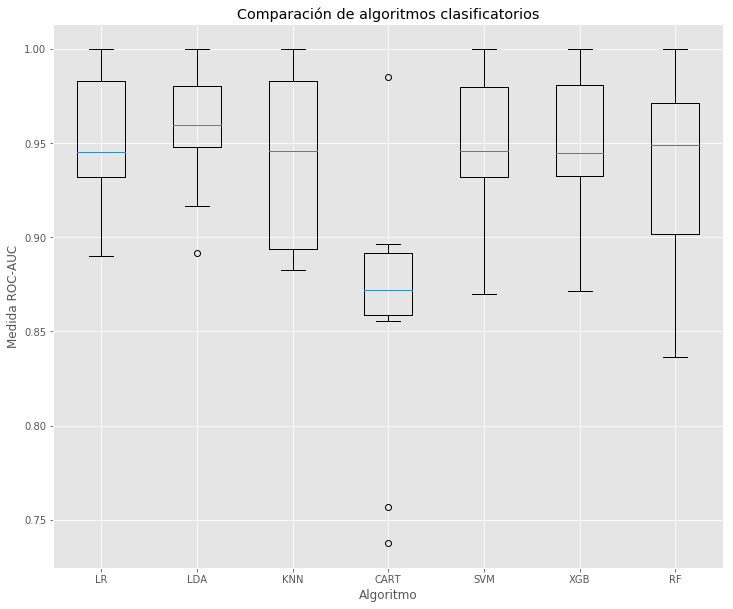

In [44]:
fig = plt.figure(figsize=(12,10))
plt.title('Comparación de algoritmos clasificatorios')
plt.xlabel('Algoritmo')
plt.ylabel('Medida ROC-AUC')
plt.boxplot(results)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
plt.show()

Visualizando Random Forest

In [45]:
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(X_train, y_train)
# Extract single atree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns.tolist(),
                class_names = ['0',' 1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)



Convierte a png usando comandos del sistema (requiere Graphviz)

In [46]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado

Mostramos en jupyter notebook

In [ ]:
from IPython.display import Image
Image(filename = 'tree.png')